# Interest Rate prediction (Classification and Unsupervised Learning)

In [13]:
import warnings
warnings.simplefilter('ignore')
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# Reading the datasets

In [14]:
train = pd.read_csv('Data/capstone_train.csv')
test = pd.read_csv('Data/capstone_test.csv')

In [15]:
train.sample(5)

,Loan_ID,Loan_Amount_Requested,Length_Employed,Home_Owner,Annual_Income,Income_Verified,Purpose_Of_Loan,Debt_To_Income,Inquiries_Last_6Mo,Months_Since_Deliquency,Number_Open_Accounts,Total_Accounts,Gender,Interest_Rate
61927,10061928,"16,000",7 years,NaN,50000.0,VERIFIED - income,debt_consolidation,13.39,0,79.0,6,12,Male,2
99959,10099960,"10,000",6 years,Mortgage,75000.0,not verified,credit_card,21.74,3,39.0,9,17,Female,2
40717,10040718,"8,550",4 years,Mortgage,NaN,VERIFIED - income,debt_consolidation,13.46,5,43.0,12,30,Male,2
98707,10098708,"8,000",6 years,Rent,60000.0,not verified,debt_consolidation,19.59,2,NaN,17,23,Female,2
150357,10150358,"14,750",2 years,Rent,NaN,not verified,debt_consolidation,14.51,2,9.0,11,36,Male,2


# Concatenating both test and train data. 
* We will be doing data treatment on the combined dataset.

In [16]:
combined_data = pd.concat((train,test))
combined_data = combined_data.drop(['Loan_ID'],axis = 1)

###### Changing Loan amount datatype since it is not a categorical column and removing comma.

In [17]:
import string
def remove_punctuation(x):
    if len(x.split(','))>1:
        return int(x.split(',')[0]+x.split(',')[1])
    else:
        return int(x)

In [18]:
combined_data['Loan_Amount_Requested'] = combined_data['Loan_Amount_Requested'].apply(remove_punctuation)

# Numerical Columns

In [19]:
combined_data.describe().T

,count,mean,std,min,25%,50%,75%,max
Loan_Amount_Requested,273850.0,14352.992240,8289.036702,500.0,8000.00,12000.00,20000.00,35000.00
Annual_Income,231850.0,73392.793977,58529.835485,3000.0,45000.00,63000.00,89000.00,7500000.00
Debt_To_Income,273850.0,17.215901,7.845967,0.0,11.36,16.85,22.78,39.99
Inquiries_Last_6Mo,273850.0,0.784543,1.036816,0.0,0.00,0.00,1.00,8.00
Months_Since_Deliquency,126612.0,34.103395,21.750307,0.0,16.00,31.00,49.00,180.00
Number_Open_Accounts,273850.0,11.186025,4.973663,0.0,8.00,10.00,14.00,84.00
Total_Accounts,273850.0,25.067975,11.589677,2.0,17.00,23.00,32.00,156.00
Interest_Rate,164309.0,2.158951,0.738364,1.0,2.00,2.00,3.00,3.00


###### Inference:

* Loan amount seems to be ok.
* Inquiries in last 6 months seems to have the least standard deviation. Maybe this variable will not play a significant role in the model building process.
* 156 Total_accounts does not seem likely. Maybe there are outliers in this column.
* 84 Open accounts also does not seem right. Will have to check for outliers.
* Debt_to_Income must also be checked. Banks usually would not give somebody so much loan that their debt is almost 2/5th of the person's salary. According to google, banks prefer to see people with **debt_to_income ratios less than 36% with no more than 28% going towards mortgages**.
* Max Annual Income also seems to be a bit disproportionate and should be checked. If a person earns **7,500,000$** dollars a year, he most likely would not be looking for a loan. This also should be checked for outlier detection.

* All the above points must be checked during univariate analysis for each column.

# Categorical Columns

In [20]:
combined_data.select_dtypes('object').describe().T

,count,unique,top,freq
Length_Employed,261543,11,10+ years,88328
Home_Owner,231790,5,Mortgage,117270
Income_Verified,273850,3,VERIFIED - income,99076
Purpose_Of_Loan,273850,14,debt_consolidation,161403
Gender,273850,2,Male,194993


###### Inference:

* All the categorical columns seem to be ok at first glance however there are missing values present in length employeed which must be checked and treated.

# Univariate Analysis
* Boxplot (For outlier detection)
* Distribution Plot (Histogram)
* Cummulative Percentage plots for all columns

## Handling Outliers

## Inspect each feature and understand the relevance of each feature by gaining domain knowledge.

##### Number_Open_Accounts

An open account by definition is an account that remains to be paid. Open account is also known as account payable by the bearer. Their terms exist in a multitude of situations: trade credit which is not fully paid, a deferred payment schedule for an item, a past due account and more. Since a person can have as many open credit lines as he wishes we cannot be assured that we can get rid of an outlier in this case.

##### Month_Since_Delinquency

Delinquency occurs when an individual or corporation with a contractual obligation to make payments against a debt, such as loan payments or the interest on a bond does not make those payments on time or in a regular, timely manner. Higher is better since the person has been making his payments on time. 0 in this case is the best since the person has never had a delinquency case in their life.

***Other numerical features are mentioned in the word document since they are self explanatory***

###### Looking at the 99th percentile values for each column

In [21]:
for i in combined_data.select_dtypes(np.number):
    print(i,':',combined_data[i].quantile(0.999))

Loan_Amount_Requested : 35000.0
Annual_Income : 500000.0
Debt_To_Income : 39.21
Inquiries_Last_6Mo : 6.0
Months_Since_Deliquency : 85.0
Number_Open_Accounts : 36.0
Total_Accounts : 72.0
Interest_Rate : 3.0


# Boxplots

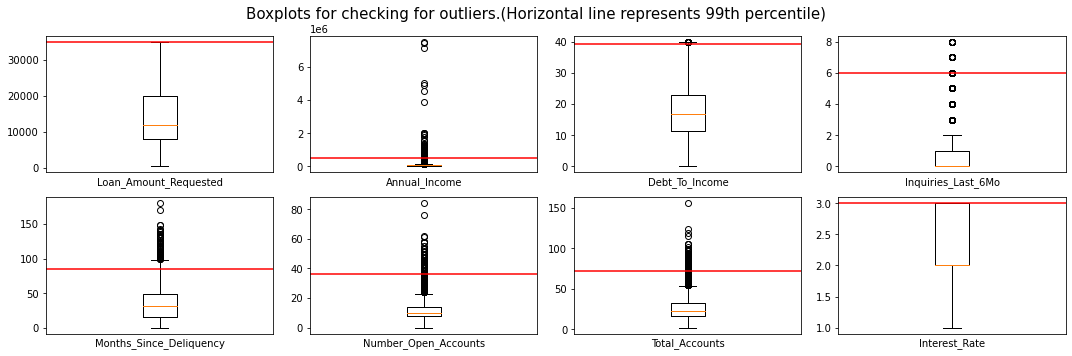

In [22]:
fig,ax = plt.subplots(nrows = 2,ncols = 4,figsize = (15,5))

for variables,plotsubs in zip(combined_data.select_dtypes(np.number).columns,ax.flatten()):
    
    plotsubs.tick_params(labelsize = 10)
    plotsubs.boxplot(combined_data[variables].dropna())
    plotsubs.axhline(combined_data[variables].quantile(0.999),color = 'r')
    plotsubs.set_xticks([])
    plotsubs.set_xlabel(variables,fontsize = 10)
    plt.tight_layout()
    plt.subplots_adjust(top = 0.90)
    
fig.suptitle('Boxplots for checking for outliers.(Horizontal line represents 99th percentile)',fontsize = 15)
plt.show()

### Removing the outliers from entire data

In [23]:
combined_data.shape

(273850, 13)

In [24]:
upper_limit = combined_data.quantile(0.995)
rdata = combined_data[~((combined_data>upper_limit).any(axis = 1))]
rdata.shape

(268624, 13)

In [25]:
print('Amount of data preserved from original dataset: {}%'.format(round(rdata.shape[0]/combined_data.shape[0]*100,2)))

Amount of data preserved from original dataset: 98.09%


## Distributions for all numerical columns

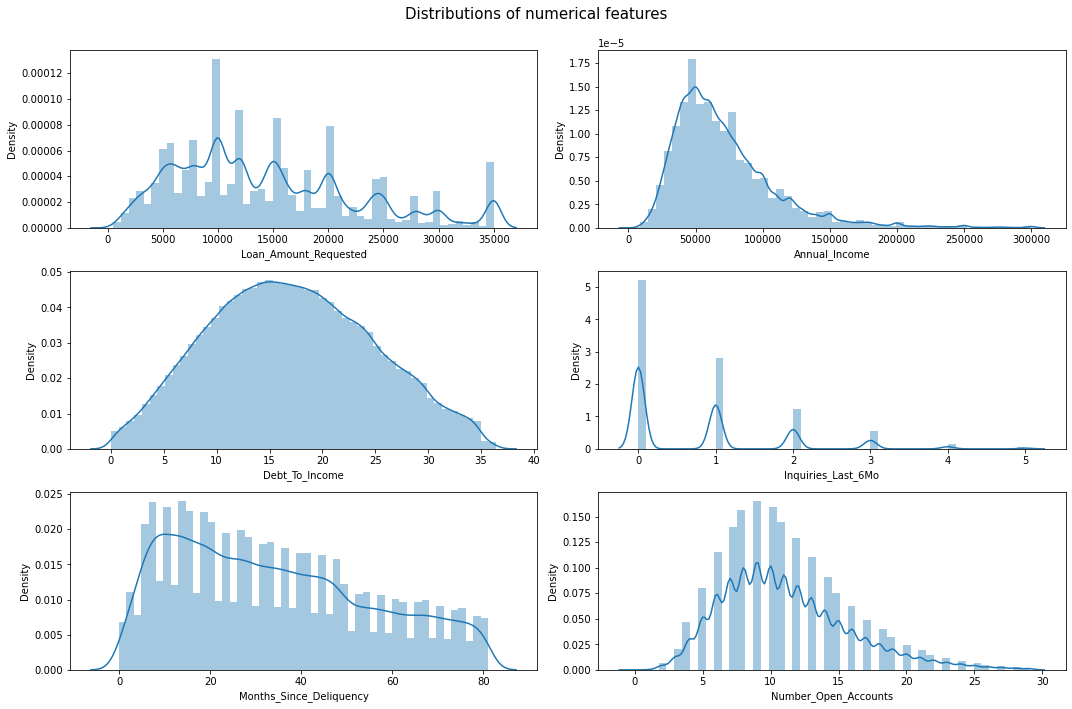

In [26]:
import warnings
warnings.simplefilter('ignore')
fig,ax = plt.subplots(nrows = 3,ncols = 2,figsize = (15,10))

for variables,plotsubs in zip(rdata.select_dtypes(np.number).columns,ax.flatten()):
    plotsubs.tick_params(labelsize = 10)
    plotsubs.set_xlabel(variables,fontsize = 10)
    sns.distplot(rdata[variables],ax = plotsubs)
    plt.tight_layout()
    plt.subplots_adjust(top = 0.92)
    
fig.suptitle('Distributions of numerical features',fontsize = 15)
plt.show()

## Target column Plot from the trainset

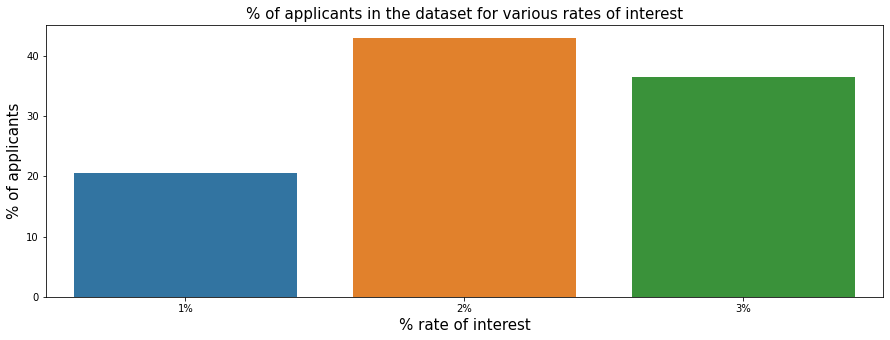

In [27]:
target_counts = (train['Interest_Rate'].value_counts()/len(train))*100
plt.figure(figsize = (15,5))
sns.barplot(target_counts.index,target_counts.values)
plt.title('% of applicants in the dataset for various rates of interest',fontsize = 15)
plt.xticks([0,1,2],labels = ['1%','2%','3%'],fontsize =10)
plt.yticks(fontsize = 10)
plt.ylabel('% of applicants',fontsize = 15)
plt.xlabel('% rate of interest',fontsize = 15)
plt.show()

### Percent plots for all categorical columns

In [28]:
rdata['Income_Verified'].replace('VERIFIED - income source','VERIFIED - income',inplace = True)

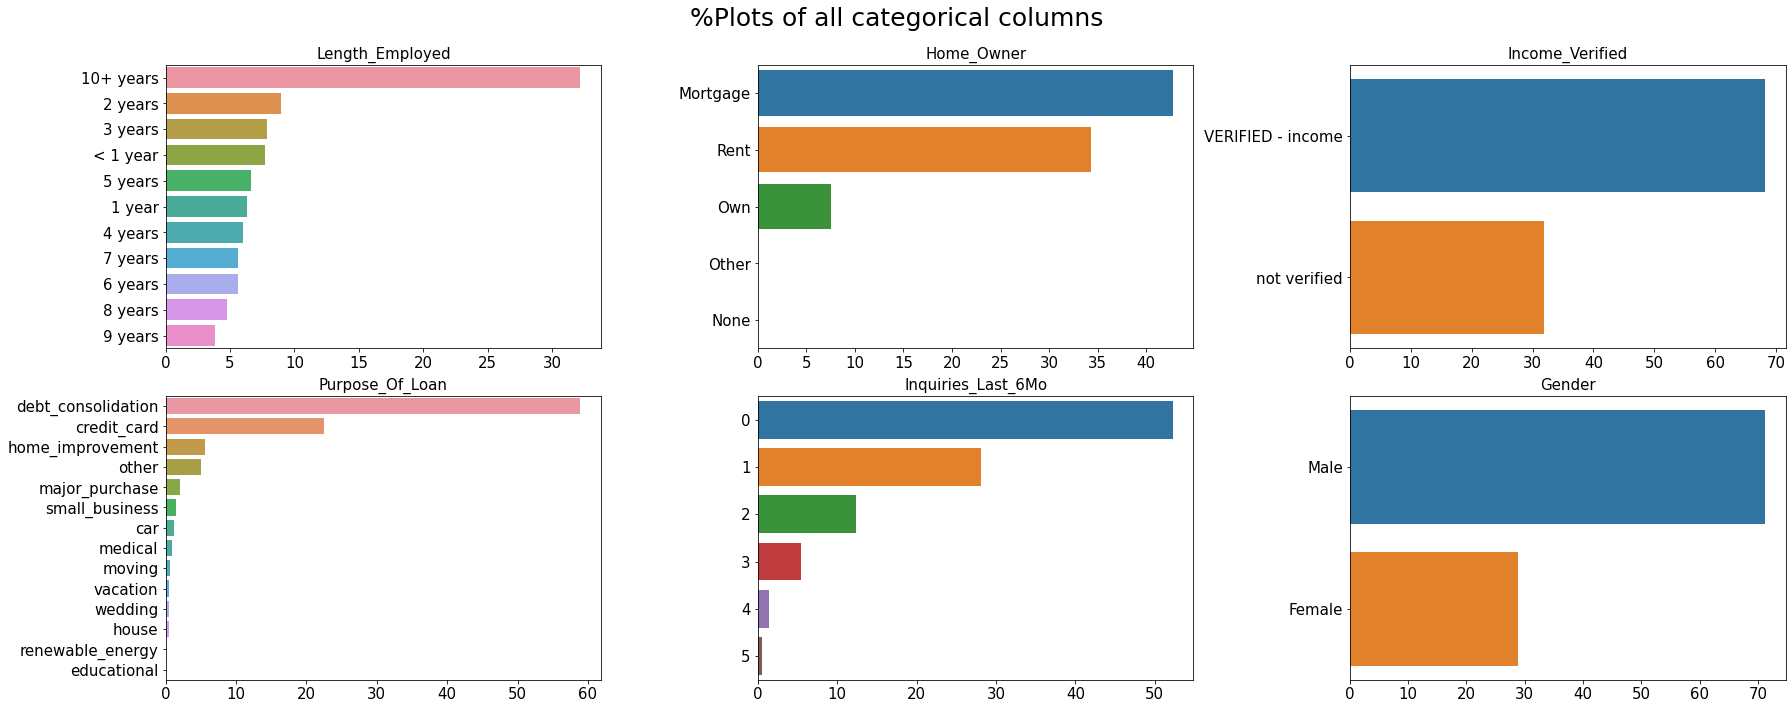

In [29]:
fig,ax = plt.subplots(nrows = 2,ncols=3,figsize = (25,10))
rdata['Inquiries_Last_6Mo'] = rdata['Inquiries_Last_6Mo'].astype('object') #Converting to object to get % count

for variables,plotsubs in zip(rdata.select_dtypes('object'),ax.flatten()):
    counts_index,counts_values = rdata[variables].value_counts().index,rdata[variables].value_counts().values/len(rdata)*100
    plotsubs.tick_params(labelsize = 15)
    plotsubs.set_title(variables,fontsize = 15)
    sns.barplot(counts_values,counts_index,ax = plotsubs,orient = 'h')
    plt.tight_layout()
    plt.subplots_adjust(top = 0.90)
    
fig.suptitle('%Plots of all categorical columns',fontsize = 25)
plt.show()

In [30]:
rdata['Inquiries_Last_6Mo'] = rdata['Inquiries_Last_6Mo'].astype(int) #Converting back to integer

#### Inferences:

* **Frequency Distributions (Numerical columns)**: 
    - We can see positive skewness in features like annual_income,loan_amount_requested since there are fewer higher income people in the world and also higher income people may not necessarily need a loan as much as lower income people.
    - Standardization is required in this data in general for correcting the problem of skewness.

* **Percent Plots**:
    - Least number of applicants get **1% rate of interest**. This is expected since banks also need to earn as much as possible.
    - People employed for more than 10 years are have applied more for a loan according to this dataset.
    - **More people have either mortgages on their home or are living on rent** in this dataset. In general in the US, many people believe in buying real estate but the process of getting a mortgage is too tedious and people prefer to rent due to its convenience and affordability according to the [federal reserve](https://www.federalreserve.gov/publications/2020-economic-well-being-of-us-households-in-2019-housing.htm).
    - **Income Verified** column can be generalized into 2 features as verified and not verified. There is duplication of verified income as it is written in 2 ways.
    - **Purpose_of_loan** is primarily debt_consolidation which means that people want to combine their previous loans into one loan by paying off the rest.
    - **Inquiries_Last_6mo**: Highest number of enquiries in 6 months is five with zero being the most frequent number of enquiries.
    - **Gender** In the dataset there are more Male applicants than Female applicants for a loan.

### Bivariate Analysis
* BoxPlots vs target
* ScatterPlots between numerical columns (Since target is categorical)

In [31]:
data_till_tgt = rdata[~(rdata['Interest_Rate'].isna())].iloc[:,:-1]
target = rdata['Interest_Rate'][~(rdata['Interest_Rate'].isna())]

#### Boxplots vs target

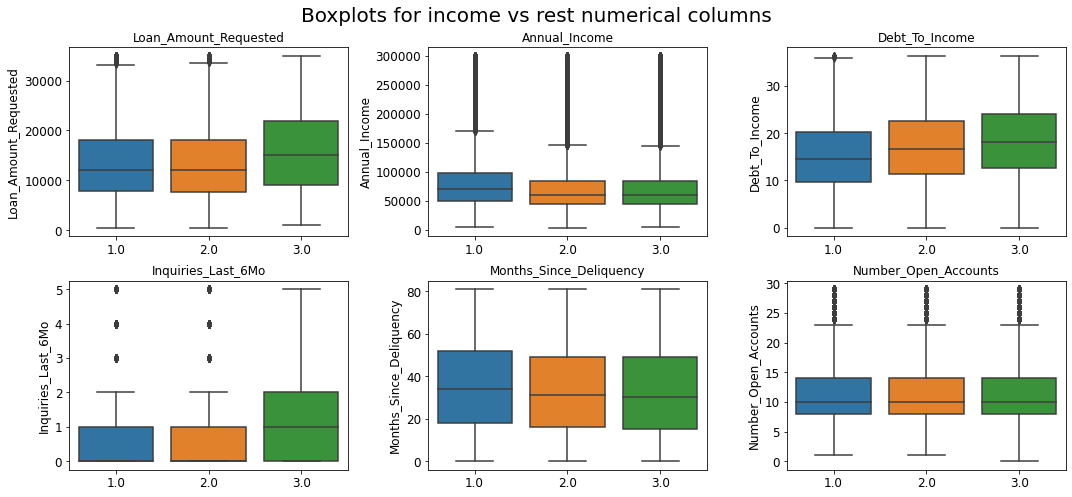

In [32]:
fig,ax = plt.subplots(nrows = 2,ncols = 3,figsize = (15,7))

for variables,plotsubs in zip(data_till_tgt.select_dtypes(np.number),ax.flatten()):
    plotsubs.tick_params(labelsize = 12)
    plotsubs.set_title(variables,fontsize = 12)
    sns.boxplot(target,data_till_tgt[variables],ax = plotsubs)
    plotsubs.set_xlabel('')
    plotsubs.set_ylabel(variables,fontsize = 12)
    plt.tight_layout()
    plt.subplots_adjust(top = 0.90)
    
fig.suptitle('Boxplots for income vs rest numerical columns',fontsize = 20)
plt.show()

## Scatterplots with numerical variables

In [33]:
continuous_cols = rdata.select_dtypes(np.number)[['Loan_Amount_Requested','Annual_Income','Debt_To_Income']]

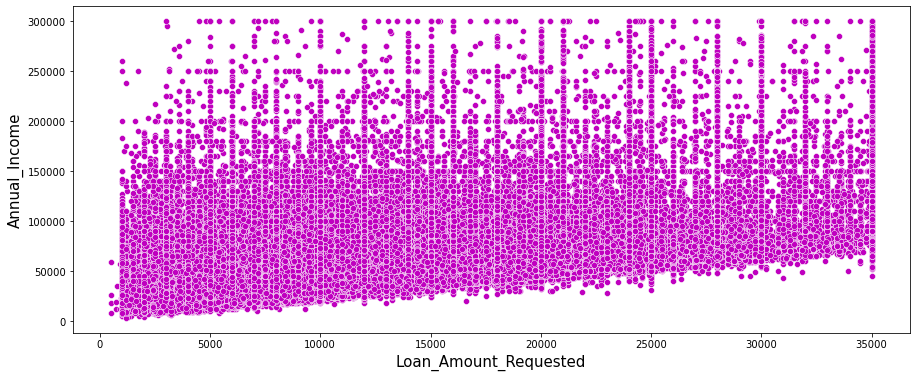

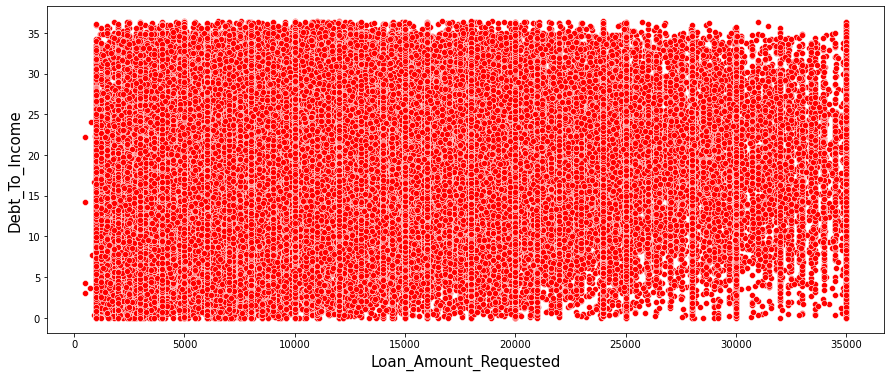

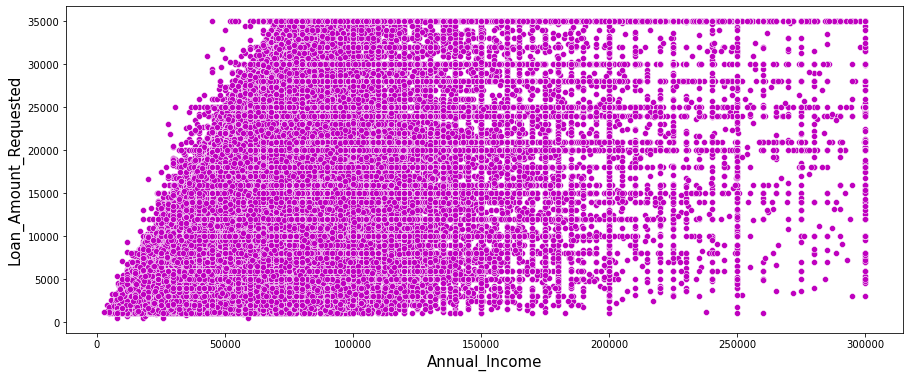

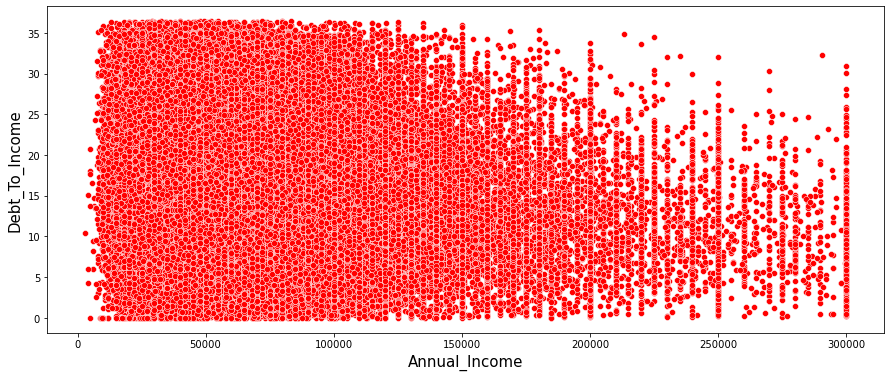

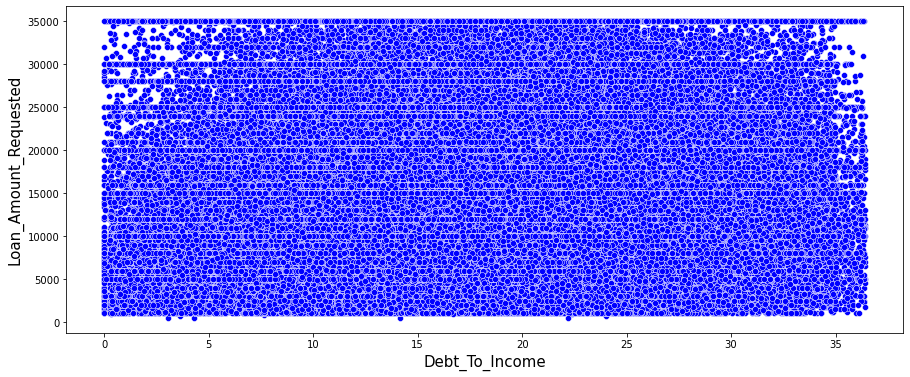

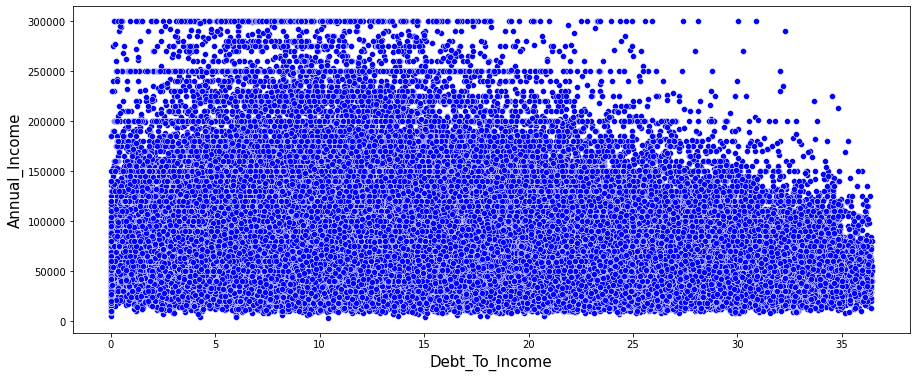

In [34]:
colors = ['m','b','r']
for i in continuous_cols.columns:
    for j in continuous_cols.columns:
        if i != j:
            plt.figure(figsize = (15,6))
            sns.scatterplot(i,j,data = continuous_cols,color = colors[np.random.randint(len(colors))])
            plt.xticks(fontsize = 10)
            plt.yticks(fontsize = 10)
            plt.xlabel(i,fontsize = 15)
            plt.ylabel(j,fontsize = 15)
            plt.show()
        else:
            pass

### Correlation Plot

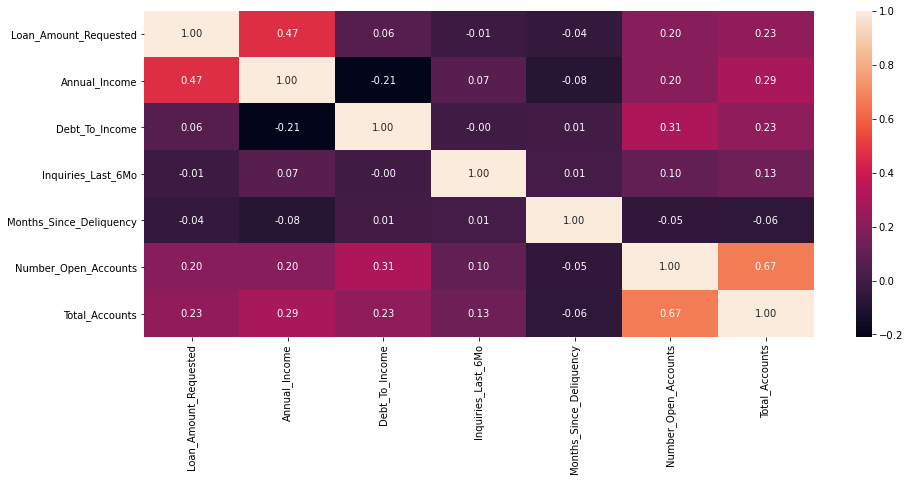

In [35]:
data_for_corr = rdata.drop('Interest_Rate',axis = 1)
correlations = data_for_corr.corr()
plt.figure(figsize=(15,6))
sns.heatmap(correlations,annot = True,fmt = '.2f')
plt.show()

### Inferences:

##### Boxplot inferences
* We can observe outliers in some of the features. But it is in the nature of such features to have outliers and hence won't be treating them any further. We could standardize the dataset to improve upon this outlier problem.


##### Scatter plot inferences
* Annual Income and loan requested seem to have a somewhat linear relationship. 
* A general downward trend is visible when we look at annual_income vs Debt_to_income. This is expected since increase in income is bound to decrease the debt value. However it also seems that in general people with more income seem to have lesser debt.
* There seems to be no direct relationship between loan_amount_requested and Debt_to_income which is again expected since people do not look at their debt_to_income ratio before requesting for a loan.


##### Correlation plot inferences
* Debt_to_Income being zero means that people don't have any debt. However Months_Since_Delinquency still has records greater than 0 in this column. This according to me means that the person has paid off his debt as of date but had defaulted on a credit card payment before. We can drop one of the two columns.

**Columns having correlation**:
* Annual_Income & Loan_Amount_Requested
* Debt_to_income & Annual Income
* Number_Open_Accounts & Total_Accounts

**Feature Engineering steps infered from correlation plot**
* We can combine annual income and loan_amount_requested as a ratio.
* We can drop Annual Income since we will be combining with loan_amount_requested
* We can take a ratio of total_accounts and number of open accounts

## Missing value treatment

* Replacing NaN in Months_Since_Deliquency with 0.
* Bin the length employed further into 0-1; 2-5; 6-10; 10+ and let KNNImputer fill nan values.
* For all other columns I have applied KNNImputer on entire dataset.

In [36]:
#If there is no available data of a person being delinquent, we can assume that he has not had any problems with repayment of his loans.
rdata['Months_Since_Deliquency'] = rdata['Months_Since_Deliquency'].fillna(0)

In [37]:
def binning_length_employed(x):
    try:
        temp = x.split()
    except:
        return np.nan
    for i in temp:
        i = i.strip().strip('+')
        if i=='<':
            return '0-1 yrs'
        elif i.isdigit():
            if i==1:
                return '0-1 yrs'
            elif int(i)>=2 and int(i)<=5:
                return '2-5 yrs'
            elif int(i)>=6 and int(i)<10:
                return '6-10 yrs'
            elif int(i)>=10:
                return '10+ yrs'

In [38]:
rdata['Length_Employed'] = rdata['Length_Employed'].apply(binning_length_employed).replace('None',np.nan)

###### Binning Purpose_of_Loan

In [39]:
pd.crosstab(rdata['Purpose_Of_Loan'],rdata['Interest_Rate'])

Interest_Rate,1.0,2.0,3.0
Purpose_Of_Loan,,,
car,658,770,432
credit_card,10409,16610,9013
debt_consolidation,16897,41553,36829
educational,36,78,6
home_improvement,2141,3760,3115
house,133,232,380
major_purchase,1044,1354,979
medical,221,554,740
moving,120,288,545


In [40]:
rdata['Purpose_Of_Loan'].unique()

array(['car', 'debt_consolidation', 'credit_card', 'home_improvement',
       'major_purchase', 'other', 'medical', 'small_business', 'moving',
       'wedding', 'vacation', 'educational', 'renewable_energy', 'house'],
      dtype=object)

In [41]:
#Personal_Expense(Vacation,wedding,small_business,moving,medical)
#Beneficial_Expense(House,Renewable_Energy,Home_Improvement,educational)
#Depreciating_Expense(Credit_Card,debt_consolidation,car,major_purchase)
#Other

In [42]:
def bin_loan_purp(x):
    if x in ['educational', 'renewable_energy', 'house','home_improvement']:
        return 'Beneficial_Expense'
    elif x in ['medical', 'small_business', 'moving','wedding', 'vacation']:
        return 'Personal_Expense'
    elif x in ['car', 'debt_consolidation', 'credit_card','major_purchase']:
        return 'Depreciating_Expense'
    else:
        return 'Other'
rdata['Purpose_Of_Loan'] = rdata['Purpose_Of_Loan'].apply(bin_loan_purp)

In [43]:
rdata.isnull().sum()[rdata.isnull().sum()>0]/len(rdata)

Length_Employed    0.108241
Home_Owner         0.153601
Annual_Income      0.153936
Interest_Rate      0.399927
dtype: float64

In [44]:
# data1 = rdata.drop('Interest_Rate',axis = 1).copy()

## Using KNNImputer to impute the missing values for Length_Employeed and Home_Owner

In [45]:
#Using only train data
data1 = rdata[~(rdata['Interest_Rate'].isna())]

In [46]:
categorical_columns = data1.select_dtypes('object').columns

In [47]:
for i in categorical_columns:
    values = data1[i].dropna().unique()
    data1[i] = data1[i].replace(values,list(range(len(values))))

In [48]:
#Standardize the data first
from sklearn.preprocessing import StandardScaler
ss = StandardScaler()
data_scaled = pd.DataFrame(ss.fit_transform(data1),columns = data1.columns)

In [49]:
import time
start = time.time()
from sklearn.impute import KNNImputer
knn_impute = KNNImputer(n_neighbors = 5)
nan_filled_data = knn_impute.fit_transform(data_scaled)
nan_filled_data = pd.DataFrame(nan_filled_data,columns = combined_data.columns)
end = time.time()
print('Execution Time:',(end-start)/60)

Execution Time: 13.27455624739329


In [51]:
data_unscaled = pd.DataFrame(ss.inverse_transform(nan_filled_data),columns = data1.columns).apply(round)
data1 = data_unscaled.replace(-0,0)

In [52]:
data1.head()

,Loan_Amount_Requested,Length_Employed,Home_Owner,Annual_Income,Income_Verified,Purpose_Of_Loan,Debt_To_Income,Inquiries_Last_6Mo,Months_Since_Deliquency,Number_Open_Accounts,Total_Accounts,Gender,Interest_Rate
0,7000.0,0.0,0.0,68000.0,0.0,0.0,18.0,0.0,0.0,9.0,14.0,0.0,1.0
1,30000.0,1.0,1.0,98060.0,1.0,0.0,15.0,0.0,17.0,12.0,24.0,0.0,3.0
2,24725.0,2.0,1.0,75566.0,1.0,0.0,16.0,0.0,0.0,12.0,16.0,1.0,3.0
3,16000.0,0.0,1.0,56160.0,1.0,0.0,14.0,3.0,0.0,16.0,22.0,1.0,3.0
4,17000.0,2.0,2.0,96000.0,1.0,0.0,22.0,1.0,0.0,19.0,30.0,0.0,1.0


In [53]:
#To convert int numbers of categorical columns back to original
for i in categorical_columns:
    data1[i] = data1[i].replace(data1[i].unique(),rdata[i].dropna().unique())

In [56]:
data1.head()

,Loan_Amount_Requested,Length_Employed,Home_Owner,Annual_Income,Income_Verified,Purpose_Of_Loan,Debt_To_Income,Inquiries_Last_6Mo,Months_Since_Deliquency,Number_Open_Accounts,Total_Accounts,Gender,Interest_Rate
0,7000.0,0-1 yrs,Rent,68000.0,not verified,Depreciating_Expense,18.0,0.0,0.0,9.0,14.0,Female,1.0
1,30000.0,2-5 yrs,Mortgage,98060.0,VERIFIED - income,Depreciating_Expense,15.0,0.0,17.0,12.0,24.0,Female,3.0
2,24725.0,6-10 yrs,Mortgage,75566.0,VERIFIED - income,Depreciating_Expense,16.0,0.0,0.0,12.0,16.0,Male,3.0
3,16000.0,0-1 yrs,Mortgage,56160.0,VERIFIED - income,Depreciating_Expense,14.0,3.0,0.0,16.0,22.0,Male,3.0
4,17000.0,6-10 yrs,Own,96000.0,VERIFIED - income,Depreciating_Expense,22.0,1.0,0.0,19.0,30.0,Female,1.0


In [55]:
# data1.to_csv('Data/filled_data.csv',index = False)
data1.to_csv('Data/filled_data_train.csv',index = False)

In [57]:
data1.head()

,Loan_Amount_Requested,Length_Employed,Home_Owner,Annual_Income,Income_Verified,Purpose_Of_Loan,Debt_To_Income,Inquiries_Last_6Mo,Months_Since_Deliquency,Number_Open_Accounts,Total_Accounts,Gender,Interest_Rate
0,7000.0,0-1 yrs,Rent,68000.0,not verified,Depreciating_Expense,18.0,0.0,0.0,9.0,14.0,Female,1.0
1,30000.0,2-5 yrs,Mortgage,98060.0,VERIFIED - income,Depreciating_Expense,15.0,0.0,17.0,12.0,24.0,Female,3.0
2,24725.0,6-10 yrs,Mortgage,75566.0,VERIFIED - income,Depreciating_Expense,16.0,0.0,0.0,12.0,16.0,Male,3.0
3,16000.0,0-1 yrs,Mortgage,56160.0,VERIFIED - income,Depreciating_Expense,14.0,3.0,0.0,16.0,22.0,Male,3.0
4,17000.0,6-10 yrs,Own,96000.0,VERIFIED - income,Depreciating_Expense,22.0,1.0,0.0,19.0,30.0,Female,1.0


## Statistical Analysis 
* Num vs Cat: Anova
* Cat vs Cat: Chi2_Contingency

In [58]:
data1 = pd.read_csv('Data/filled_data_train.csv')
data1.head(2)

,Loan_Amount_Requested,Length_Employed,Home_Owner,Annual_Income,Income_Verified,Purpose_Of_Loan,Debt_To_Income,Inquiries_Last_6Mo,Months_Since_Deliquency,Number_Open_Accounts,Total_Accounts,Gender,Interest_Rate
0,7000.0,0-1 yrs,Rent,68000.0,not verified,Depreciating_Expense,18.0,0.0,0.0,9.0,14.0,Female,1.0
1,30000.0,2-5 yrs,Mortgage,98060.0,VERIFIED - income,Depreciating_Expense,15.0,0.0,17.0,12.0,24.0,Female,3.0


In [59]:
data1.describe().T

,count,mean,std,min,25%,50%,75%,max
Loan_Amount_Requested,161194.0,14287.025727,8240.749114,500.0,8000.0,12000.0,20000.0,35000.0
Annual_Income,161194.0,71248.609737,37028.360269,4000.0,46000.0,63176.0,87000.0,300000.0
Debt_To_Income,161194.0,17.103577,7.710706,0.0,11.0,17.0,23.0,36.0
Inquiries_Last_6Mo,161194.0,0.766890,1.002490,0.0,0.0,0.0,1.0,5.0
Months_Since_Deliquency,161194.0,15.665037,22.384749,0.0,0.0,0.0,28.0,81.0
Number_Open_Accounts,161194.0,11.048656,4.711704,0.0,8.0,10.0,14.0,29.0
Total_Accounts,161194.0,24.781071,11.193117,2.0,16.0,23.0,32.0,63.0
Interest_Rate,161194.0,2.156402,0.738652,1.0,2.0,2.0,3.0,3.0


In [60]:
data_for_stats = data1.copy()

In [61]:
#Convert Interest Rate column to category
# data_for_stats['Interest_Rate'] = data_for_stats['Interest_Rate'].astype('category')

### Anova Test

* Performing Anova test to check if for each category there is a difference in mean for the respective numerical columns.

In [62]:
from statsmodels.formula.api import ols
import statsmodels.api as sm
model = ols("Interest_Rate~Loan_Amount_Requested+Annual_Income+Debt_To_Income+Inquiries_Last_6Mo+Months_Since_Deliquency+Number_Open_Accounts+Total_Accounts+Number_Open_Accounts:Total_Accounts+Loan_Amount_Requested:Annual_Income",data_for_stats).fit()
sm.stats.anova_lm(model)

,df,sum_sq,mean_sq,F,PR(>F)
Loan_Amount_Requested,1.0,1548.668788,1548.668788,3215.185244,0.000000e+00
Annual_Income,1.0,2519.370487,2519.370487,5230.455263,0.000000e+00
Debt_To_Income,1.0,834.405849,834.405849,1732.306736,0.000000e+00
Inquiries_Last_6Mo,1.0,3727.481451,3727.481451,7738.609735,0.000000e+00
Months_Since_Deliquency,1.0,470.502812,470.502812,976.809056,8.642641e-214
Number_Open_Accounts,1.0,347.026920,347.026920,720.461237,2.376488e-158
Total_Accounts,1.0,673.707821,673.707821,1398.682185,8.334261e-305
Number_Open_Accounts:Total_Accounts,1.0,115.191792,115.191792,239.149231,6.592050e-54
Loan_Amount_Requested:Annual_Income,1.0,73.579019,73.579019,152.757115,4.490231e-35
Residual,161184.0,77638.024247,0.481673,NaN,NaN


In [63]:
sm.stats.anova_lm(model)['PR(>F)']>0.05

Loan_Amount_Requested                  False
Annual_Income                          False
Debt_To_Income                         False
Inquiries_Last_6Mo                     False
Months_Since_Deliquency                False
Number_Open_Accounts                   False
Total_Accounts                         False
Number_Open_Accounts:Total_Accounts    False
Loan_Amount_Requested:Annual_Income    False
Residual                               False
Name: PR(>F), dtype: bool

###### Pairwise Tukey_HSD test

In [64]:
def tukey(col):
    from statsmodels.stats.multicomp import pairwise_tukeyhsd
    print("\033[1m"+'Tukey HSD test for {} is:'.format(col)+"\033[0;0m")
    return print(pairwise_tukeyhsd(data_for_stats[col],data_for_stats['Interest_Rate'])),print('*'*80)

In [65]:
for i in data_for_stats.select_dtypes(np.number).drop('Interest_Rate',axis = 1).columns:
    tukey(i)

Tukey HSD test for Loan_Amount_Requested is:
   Multiple Comparison of Means - Tukey HSD, FWER=0.05   
group1 group2  meandiff p-adj    lower     upper   reject
---------------------------------------------------------
   1.0    2.0    79.793 0.3061  -47.4466  207.0327  False
   1.0    3.0 2653.5318  0.001 2522.5524 2784.5113   True
   2.0    3.0 2573.7388  0.001 2466.5793 2680.8983   True
---------------------------------------------------------
********************************************************************************
Tukey HSD test for Annual_Income is:
    Multiple Comparison of Means - Tukey HSD, FWER=0.05     
group1 group2  meandiff  p-adj    lower      upper    reject
------------------------------------------------------------
   1.0    2.0 -9437.9326 0.001 -10013.2549 -8862.6103   True
   1.0    3.0 -9489.8473 0.001 -10082.0793 -8897.6152   True
   2.0    3.0   -51.9147   0.9   -536.4432   432.6138  False
------------------------------------------------------------
****

### Anova for all categorical columns vs numerical columns

In [66]:
from statsmodels.formula.api import ols
import statsmodels.api as sm
from sklearn.preprocessing import LabelEncoder
for i in data_for_stats.select_dtypes('object').columns:
    num_vals = data_for_stats.copy()
    num_vals[i] = LabelEncoder().fit_transform(data_for_stats[i])
    model = ols(i+"~Loan_Amount_Requested+Annual_Income+Debt_To_Income+Inquiries_Last_6Mo+Months_Since_Deliquency+Number_Open_Accounts+Total_Accounts",num_vals).fit()
    print("\033[1m"+'ANOVA Test For {} vs All Numerical Features'.format(i)+"\033[0;0m")
    print(sm.stats.anova_lm(model).loc[:,'PR(>F)'])
    print('*'*55)

ANOVA Test For Length_Employed vs All Numerical Features
Loan_Amount_Requested      3.059868e-70
Annual_Income              6.442370e-43
Debt_To_Income             9.090794e-01
Inquiries_Last_6Mo         8.517549e-02
Months_Since_Deliquency    9.783889e-01
Number_Open_Accounts       9.939324e-02
Total_Accounts             6.972583e-51
Residual                            NaN
Name: PR(>F), dtype: float64
*******************************************************
ANOVA Test For Home_Owner vs All Numerical Features
Loan_Amount_Requested       0.000000e+00
Annual_Income               0.000000e+00
Debt_To_Income              4.072331e-61
Inquiries_Last_6Mo          9.835011e-96
Months_Since_Deliquency     6.379993e-18
Number_Open_Accounts       8.113604e-183
Total_Accounts              0.000000e+00
Residual                             NaN
Name: PR(>F), dtype: float64
*******************************************************
ANOVA Test For Income_Verified vs All Numerical Features
Loan_Amount_Requ

###### Chi Square test (Cat vs Cat)

In [67]:
from scipy.stats import chi2_contingency
cat_cols = data_for_stats.select_dtypes('object').columns
pval = []
for i in cat_cols:
    cross_tabbed = pd.crosstab(data_for_stats[i],data_for_stats['Interest_Rate'])
    fstat,pvalue,df,freq = chi2_contingency(cross_tabbed)
    pval.append(pvalue)
chi_out = pd.DataFrame({'Feature':cat_cols,'chi_pvalue':pval})
chi_out

,Feature,chi_pvalue
0,Length_Employed,2.483199e-29
1,Home_Owner,9.487405e-172
2,Income_Verified,0.000000e+00
3,Purpose_Of_Loan,0.000000e+00
4,Gender,1.222438e-01


In [68]:
print('There is no difference between the rates of interest provided based on gender since its pvalue is greater than 0.05.')
chi_out[chi_out['chi_pvalue']>0.05]

There is no difference between the rates of interest provided based on gender since its pvalue is greater than 0.05.


,Feature,chi_pvalue
4,Gender,0.122244


##### ttest for 2 categorical variables with only 2 categories

In [69]:
#Gender and income_verified seem to have only 2 categories each. These features can be compared using ttest.

#Creating a function for independent ttest
def ttest_calc(f_data,col_name,col_name1):
    print()
    ttest_pos_rec = f_data[f_data[col_name] == f_data[col_name].unique()[0]][col_name1]
    ttest_pos_nrec = f_data[f_data[col_name] == f_data[col_name].unique()[1]][col_name1]
    teststat,pval = stats.ttest_ind(ttest_pos_rec,ttest_pos_nrec)
    if pval<0.05:
        print("T-test for {} is having:\np-value: {}\nWe can conclude that {} feature has a relation with {}\n".format(col_name,pval,col_name,col_name1))
    else:
        print("T-test for {} is having:\np-value: {}\nWe can conclude that {} feature has no relation with {}.\n".format(col_name,pval,col_name,col_name1))
    print('*'*85)
    print()

In [70]:
#Income_Verified and Gender have only 2 categories. We can apply ttest on these features with other numerical features in the dataset.
from scipy.stats import stats
print('*'*85)
for j in ['Gender','Income_Verified']:
    for i in data_for_stats.select_dtypes(np.number).iloc[:,:-1].columns:
        ttest_calc(data_for_stats,j,i)

*************************************************************************************

T-test for Gender is having:
p-value: 0.5675419387612254
We can conclude that Gender feature has no relation with Loan_Amount_Requested.

*************************************************************************************


T-test for Gender is having:
p-value: 0.4202175439682918
We can conclude that Gender feature has no relation with Annual_Income.

*************************************************************************************


T-test for Gender is having:
p-value: 0.6885295486446477
We can conclude that Gender feature has no relation with Debt_To_Income.

*************************************************************************************


T-test for Gender is having:
p-value: 0.8206366242212721
We can conclude that Gender feature has no relation with Inquiries_Last_6Mo.

*************************************************************************************


T-test for Gender is having

### Inferences

###### Anova Test
* From the Anova test we can conclude that **all the numerical features are significant and are playing a role in making a prediction for Interest Rates.**
* The **pairwise_tukeyhsd tests for all the features also confirms the same.**

* Anova test on other categorical columns as the target and numerical columns shows that **baring gender, all other categorical columns can be target variables** for the present numerical features.

###### ChiSquare Test
* From the chi-square test **'Gender' seemed to be the only feature that had a p-value>0.05 and hence was not significant.** All the other features are having some predictive power for rate of interest.

###### ttest Independent
* On checking for Gender and Income_Verified, it was found the **Income_Verified was playing an impact on all the numerical features present in the dataset.** We could drop this feature during the model building process.

## Feature Engineering

Feature Engineering steps infered from correlation plot

    - We can combine annual income and loan_amount_requested as a ratio and drop both these columns.
    - We can drop Annual Income since we will be combining with loan_amount_requested.
    - We can take a ratio of total_accounts and number of open accounts and drop both the columns.


In [214]:
data1 = pd.read_csv('Data/filled_data_train.csv')
data1.head()

,Loan_Amount_Requested,Length_Employed,Home_Owner,Annual_Income,Income_Verified,Purpose_Of_Loan,Debt_To_Income,Inquiries_Last_6Mo,Months_Since_Deliquency,Number_Open_Accounts,Total_Accounts,Gender,Interest_Rate
0,7000.0,0-1 yrs,Rent,68000.0,not verified,Depreciating_Expense,18.0,0.0,0.0,9.0,14.0,Female,1.0
1,30000.0,2-5 yrs,Mortgage,98060.0,VERIFIED - income,Depreciating_Expense,15.0,0.0,17.0,12.0,24.0,Female,3.0
2,24725.0,6-10 yrs,Mortgage,75566.0,VERIFIED - income,Depreciating_Expense,16.0,0.0,0.0,12.0,16.0,Male,3.0
3,16000.0,0-1 yrs,Mortgage,56160.0,VERIFIED - income,Depreciating_Expense,14.0,3.0,0.0,16.0,22.0,Male,3.0
4,17000.0,6-10 yrs,Own,96000.0,VERIFIED - income,Depreciating_Expense,22.0,1.0,0.0,19.0,30.0,Female,1.0


###### Creating new features

In [215]:
#Combining annual_income and laon_amount_requested
data1['amt_req:annual_income'] = data1['Loan_Amount_Requested']/data1['Annual_Income']
# Take ratio of total_accounts and no._open_accounts as open to total accounts
data1['Open_acc:Total_acc'] = data1['Number_Open_Accounts']/data1['Total_Accounts']
#Create a new column called closed accounts
data1['Closed_accounts'] = data1['Total_Accounts']-data1['Number_Open_Accounts']
#Create a new column called closed_acc:total_acc
data1['Closed_acc:Total_acc'] = data1['Closed_accounts']/data1['Total_Accounts']

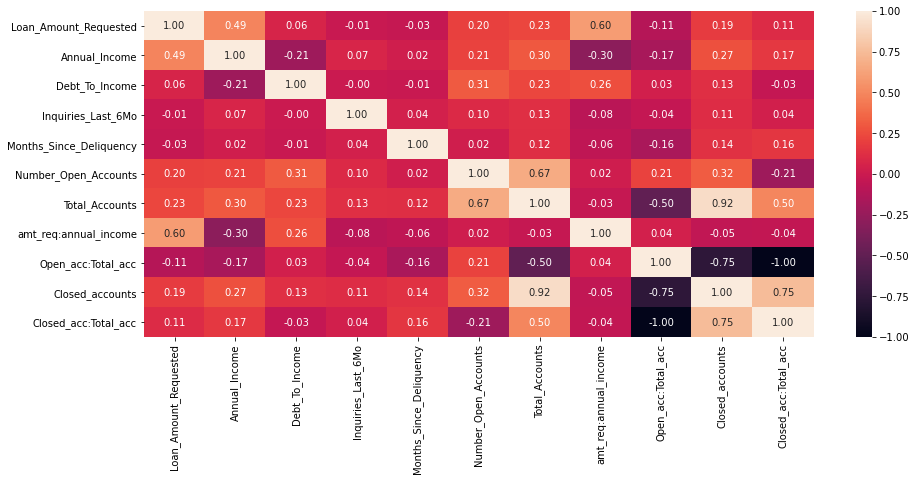

In [216]:
plt.figure(figsize = (15,6))
sns.heatmap(data1.drop(['Interest_Rate'],axis = 1).corr(),annot = True,fmt = '.2f')
plt.show()

###### Applying Recursive Feature Elimination to fing the best features in our dataset.

In [230]:
from sklearn.feature_selection import RFE
from sklearn.linear_model import LogisticRegression
rfe = RFE(DecisionTreeClassifier(),n_features_to_select=20)
encoded_data = pd.get_dummies(data1,drop_first = True)
X = encoded_data.drop('Interest_Rate',axis = 1)
y = data1['Interest_Rate']
new_input = rfe.fit_transform(X,y)
rfe.score(X,y)

1.0

In [231]:
X.columns[rfe.get_support()]

Index(['Loan_Amount_Requested', 'Annual_Income', 'Debt_To_Income',
       'Inquiries_Last_6Mo', 'Months_Since_Deliquency', 'Number_Open_Accounts',
       'Total_Accounts', 'amt_req:annual_income', 'Open_acc:Total_acc',
       'Closed_accounts', 'Closed_acc:Total_acc', 'Length_Employed_10+ yrs',
       'Length_Employed_2-5 yrs', 'Length_Employed_6-10 yrs', 'Home_Owner_Own',
       'Home_Owner_Rent', 'Income_Verified_not verified',
       'Purpose_Of_Loan_Depreciating_Expense', 'Purpose_Of_Loan_Other',
       'Gender_Male'],
      dtype='object')

In [232]:
#Let us remove some columns as they are highly correlated
#Remove Annual_Income
data1 = encoded_data[['Loan_Amount_Requested', 'Annual_Income', 'Debt_To_Income',
       'Inquiries_Last_6Mo', 'Months_Since_Deliquency', 'Number_Open_Accounts',
       'Total_Accounts', 'amt_req:annual_income', 'Open_acc:Total_acc',
       'Closed_accounts', 'Closed_acc:Total_acc', 'Length_Employed_10+ yrs',
       'Length_Employed_2-5 yrs', 'Length_Employed_6-10 yrs', 'Home_Owner_Own',
       'Home_Owner_Rent', 'Income_Verified_not verified',
       'Purpose_Of_Loan_Depreciating_Expense', 'Purpose_Of_Loan_Other',
       'Gender_Male']]

In [233]:
# pd.get_dummies(data1)
data1

,Loan_Amount_Requested,Annual_Income,Debt_To_Income,Inquiries_Last_6Mo,Months_Since_Deliquency,Number_Open_Accounts,Total_Accounts,amt_req:annual_income,Open_acc:Total_acc,Closed_accounts,Closed_acc:Total_acc,Length_Employed_10+ yrs,Length_Employed_2-5 yrs,Length_Employed_6-10 yrs,Home_Owner_Own,Home_Owner_Rent,Income_Verified_not verified,Purpose_Of_Loan_Depreciating_Expense,Purpose_Of_Loan_Other,Gender_Male
0,7000.0,68000.0,18.0,0.0,0.0,9.0,14.0,0.102941,0.642857,5.0,0.357143,0,0,0,0,1,1,1,0,0
1,30000.0,98060.0,15.0,0.0,17.0,12.0,24.0,0.305935,0.500000,12.0,0.500000,0,1,0,0,0,0,1,0,0
2,24725.0,75566.0,16.0,0.0,0.0,12.0,16.0,0.327197,0.750000,4.0,0.250000,0,0,1,0,0,0,1,0,1
3,16000.0,56160.0,14.0,3.0,0.0,16.0,22.0,0.284900,0.727273,6.0,0.272727,0,0,0,0,0,0,1,0,1
4,17000.0,96000.0,22.0,1.0,0.0,19.0,30.0,0.177083,0.633333,11.0,0.366667,0,0,1,1,0,0,1,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
161189,20725.0,85600.0,14.0,0.0,0.0,13.0,16.0,0.242114,0.812500,3.0,0.187500,1,0,0,0,1,0,1,0,1
161190,6000.0,76102.0,9.0,0.0,36.0,13.0,30.0,0.078842,0.433333,17.0,0.566667,0,0,1,1,0,0,0,0,1
161191,20250.0,85600.0,18.0,1.0,0.0,17.0,30.0,0.236565,0.566667,13.0,0.433333,1,0,0,0,0,0,1,0,1
161192,10000.0,82400.0,19.0,1.0,48.0,16.0,62.0,0.121359,0.258065,46.0,0.741935,0,1,0,0,1,1,1,0,0


# Model Building

### Problem Statement 1 (Supervised ML):

    - Predicting the Interest rate on a loan application given pertaining parameters related to loan.

### Problem Statement 2 (Unsupervised ML):
    
    - To arrive at the segmentation of customers concerning their past data of loans on different parameters. This segmentation will then be used to map different interest rate slabs(1/2/3)to these customers.

# Classification (Supervised Learning)

* **Target Variable:** Interest_Rate

In [2]:
data1.columns

NameError: name 'data1' is not defined

###### Importing libraries

###### Performing one_hot_encoding

In [235]:
# new_data = pd.get_dummies(df,drop_first = True)

In [236]:
# new_data.head()

###### Splitting into dependent and independent variables

In [1]:
X = data1
y = new_data['Interest_Rate']

NameError: name 'data1' is not defined

###### Creating train_test_split

In [242]:
X_train,X_test,y_train,y_test = train_test_split(X,y,test_size = 0.25,random_state = 6)
X_train.shape,X_test.shape,y_train.shape,y_test.shape

((120895, 20), (40299, 20), (120895,), (40299,))

## Logistic Regression

In [243]:
from sklearn.preprocessing import StandardScaler
ss = StandardScaler()
X1 = data1
y1 = new_data['Interest_Rate']
X_train1 = ss.fit_transform(X1)
X_train1,X_test1,y_train,y_test = train_test_split(X1,y1,test_size = 0.25,random_state = 6)
X_train1.shape,X_test1.shape,y_train.shape,y_test.shape

((120895, 20), (40299, 20), (120895,), (40299,))

In [245]:
from sklearn.linear_model import LogisticRegression
lr = LogisticRegression(max_iter = 100)
lr.fit(X_train,y_train)
lr.score(X_test,y_test)

0.45896920519119583

## Common Base function for all algorithms

In [246]:
def model_function(model,X_train,X_test,y_train,y_test):
    #Fitting the model
    model = model
    model.fit(X_train,y_train)
    y_pred = model.predict(X_test)
    print('*'*95)
    print("\n"+"\033[1m"+'Model Report for '+str(model)+"\033[0;0m"+"\n")
    print('*'*95)

    #Performance metrics
    from sklearn.metrics import classification_report
    print(classification_report(y_test,y_pred))

    #Confusion_Matrix
    from sklearn.metrics import confusion_matrix
    cm = confusion_matrix(y_test,y_pred)
    plt.figure(figsize = (15,6))
    sns.heatmap(cm,annot = True,fmt = '.2f')
    plt.title('Confusion Matrix')
    plt.xticks([0.5,1.5,2.5],[1,2,3])
    plt.yticks([0.5,1.5,2.5],[1,2,3])
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.show()

def grid_search(estimator,params,X_train,y_train,cv=5,v=0):
    from sklearn.model_selection import GridSearchCV
    grid = GridSearchCV(estimator,params,scoring = 'roc_auc',n_jobs = -1,cv = cv,verbose = v)
    grid.fit(X_train,y_train)
    return grid.best_params_

## DecisionTreeClassifier

***********************************************************************************************

Model Report for DecisionTreeClassifier()

***********************************************************************************************
              precision    recall  f1-score   support

         1.0       0.31      0.32      0.32      8342
         2.0       0.45      0.45      0.45     17393
         3.0       0.46      0.46      0.46     14564

    accuracy                           0.42     40299
   macro avg       0.41      0.41      0.41     40299
weighted avg       0.43      0.42      0.43     40299



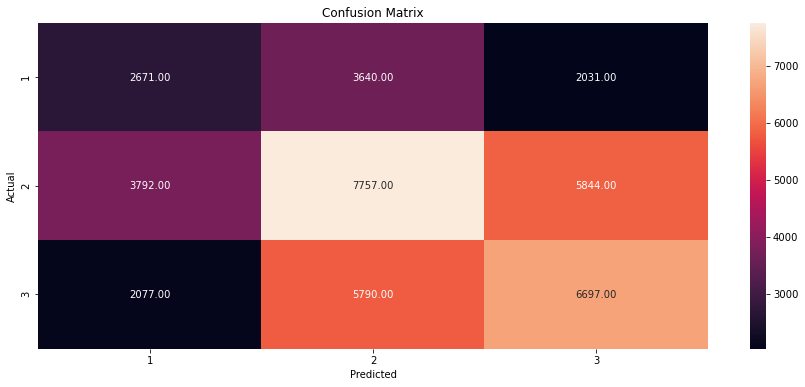

In [247]:
from sklearn.tree import DecisionTreeClassifier
dtc = DecisionTreeClassifier()
model_function(dtc,X_train,X_test,y_train,y_test)

In [250]:
params = {'max_depth':[50,100,150,200,250,300],
         'criterion':['gini','entropy'],
         }
from sklearn.model_selection import GridSearchCV
grid = GridSearchCV(DecisionTreeClassifier(),params,scoring = 'accuracy',cv = 5,verbose = 1)
gs = grid.fit(X_train,y_train)

Fitting 5 folds for each of 12 candidates, totalling 60 fits


KeyboardInterrupt: 

## ExtraTreesClassifier

***********************************************************************************************

Model Report for ExtraTreesClassifier()

***********************************************************************************************
              precision    recall  f1-score   support

         1.0       0.42      0.25      0.31      8342
         2.0       0.48      0.58      0.52     17393
         3.0       0.52      0.50      0.51     14564

    accuracy                           0.48     40299
   macro avg       0.47      0.44      0.45     40299
weighted avg       0.48      0.48      0.47     40299



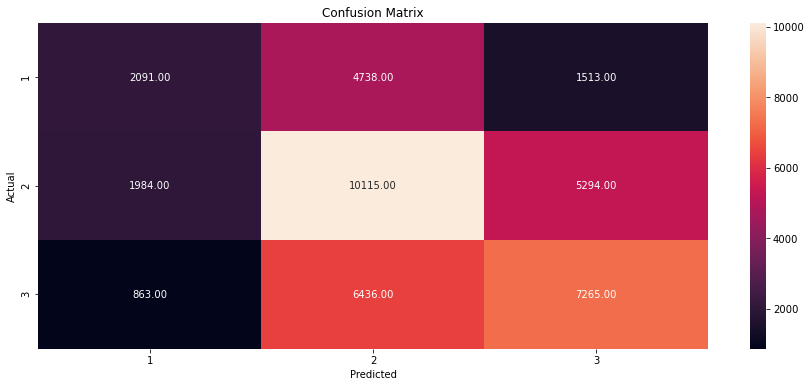

In [204]:
from sklearn.ensemble import ExtraTreesClassifier
etc = ExtraTreesClassifier()
model_function(etc,X_train,X_test,y_train,y_test)

## RandomForestClassifier

***********************************************************************************************

Model Report for RandomForestClassifier()

***********************************************************************************************
              precision    recall  f1-score   support

         1.0       0.45      0.27      0.34      8342
         2.0       0.48      0.58      0.53     17393
         3.0       0.53      0.51      0.52     14564

    accuracy                           0.49     40299
   macro avg       0.49      0.46      0.46     40299
weighted avg       0.49      0.49      0.49     40299



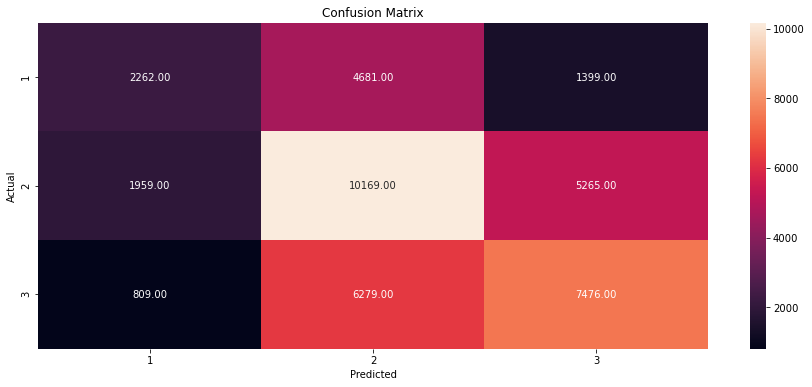

In [205]:
from sklearn.ensemble import RandomForestClassifier
rfc = RandomForestClassifier()
model_function(rfc,X_train,X_test,y_train,y_test)

In [ ]:
params = {'n_estimators':[5,50,100,200],
         'max_depth':[50,100,150,200,250,300],
         'criterion':['gini','entropy'],         
         }
from sklearn.model_selection import GridSearchCV
grid = GridSearchCV(RandomForestClassifier(),params,scoring = 'accuracy',cv = 5,verbose = 1)
gs = grid.fit(X_train,y_train)

### NaiveBayesClassifier

***********************************************************************************************

Model Report for MultinomialNB()

***********************************************************************************************
              precision    recall  f1-score   support

         1.0       0.27      0.54      0.36      8342
         2.0       0.45      0.11      0.18     17393
         3.0       0.44      0.59      0.50     14564

    accuracy                           0.37     40299
   macro avg       0.39      0.41      0.35     40299
weighted avg       0.41      0.37      0.33     40299



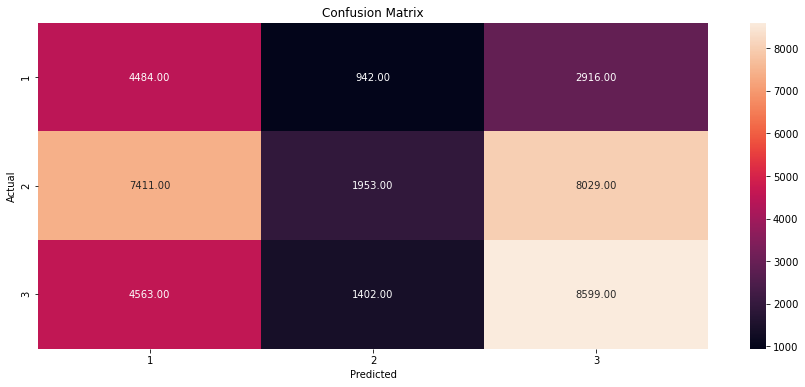

In [206]:
from sklearn.naive_bayes import MultinomialNB
mnb = MultinomialNB()
model_function(mnb,X_train,X_test,y_train,y_test)

### BaggingClassifier

***********************************************************************************************

Model Report for BaggingClassifier(base_estimator=MultinomialNB())

***********************************************************************************************
              precision    recall  f1-score   support

         1.0       0.27      0.54      0.36      8342
         2.0       0.45      0.11      0.18     17393
         3.0       0.44      0.59      0.50     14564

    accuracy                           0.37     40299
   macro avg       0.39      0.41      0.35     40299
weighted avg       0.41      0.37      0.33     40299



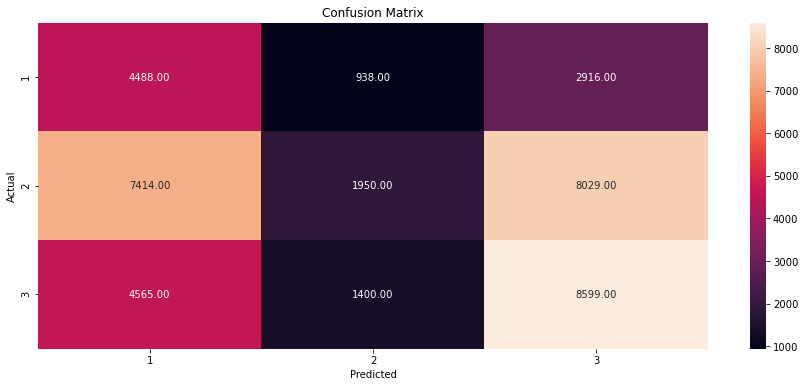

In [207]:
from sklearn.ensemble import BaggingClassifier
bag = BaggingClassifier(mnb)
model_function(bag,X_train,X_test,y_train,y_test)

### VotingClassifier

***********************************************************************************************

Model Report for VotingClassifier(estimators=[('Logistic_Reg', LogisticRegression()),
                             ('NaiveBayes', MultinomialNB()),
                             ('DecisionTree', DecisionTreeClassifier())])

***********************************************************************************************
              precision    recall  f1-score   support

         1.0       0.28      0.37      0.32      8342
         2.0       0.46      0.37      0.41     17393
         3.0       0.47      0.50      0.49     14564

    accuracy                           0.42     40299
   macro avg       0.40      0.41      0.40     40299
weighted avg       0.43      0.42      0.42     40299



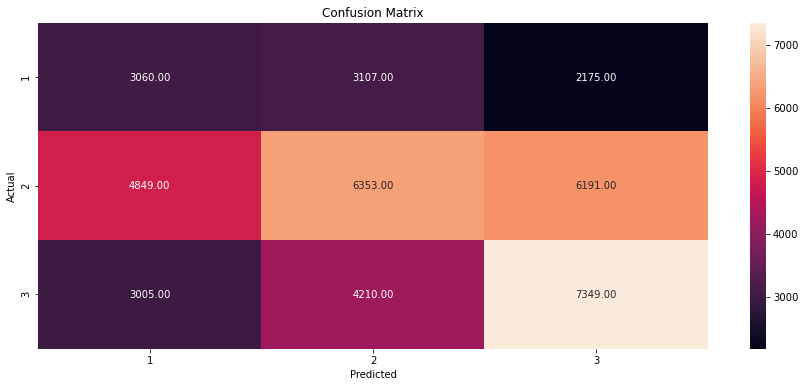

In [208]:
from sklearn.ensemble import VotingClassifier
vote = VotingClassifier([('Logistic_Reg',lr),('NaiveBayes',mnb),('DecisionTree',dtc)])
model_function(vote,X_train,X_test,y_train,y_test)

### GradientBoostingClassifier

***********************************************************************************************

Model Report for GradientBoostingClassifier()

***********************************************************************************************
              precision    recall  f1-score   support

         1.0       0.52      0.21      0.30      8342
         2.0       0.49      0.66      0.56     17393
         3.0       0.57      0.51      0.54     14564

    accuracy                           0.52     40299
   macro avg       0.52      0.46      0.47     40299
weighted avg       0.52      0.52      0.50     40299



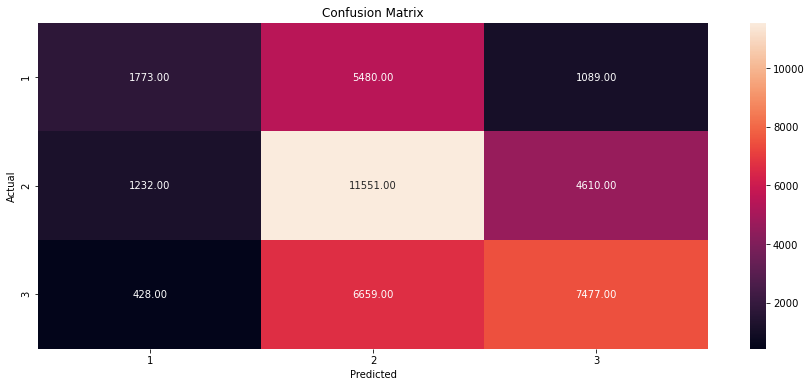

In [209]:
from sklearn.ensemble import GradientBoostingClassifier
gbc = GradientBoostingClassifier()
model_function(gbc,X_train,X_test,y_train,y_test)

In [ ]:
params = {'learning_rate':[0.01,0.05,0.1,0.15,0.2]
        'max_depth':[50,100,150,200,250,300],
         'criterion':['gini','entropy'],
         }
from sklearn.model_selection import GridSearchCV
grid = GridSearchCV(ExtraTreesClassifier(),params,scoring = 'accuracy',cv = 5,verbose = 1)
gs = grid.fit(X_train,y_train)

### AdaboostClassifier

***********************************************************************************************

Model Report for AdaBoostClassifier()

***********************************************************************************************
              precision    recall  f1-score   support

         1.0       0.50      0.23      0.31      8342
         2.0       0.48      0.65      0.56     17393
         3.0       0.56      0.50      0.53     14564

    accuracy                           0.51     40299
   macro avg       0.52      0.46      0.47     40299
weighted avg       0.52      0.51      0.50     40299



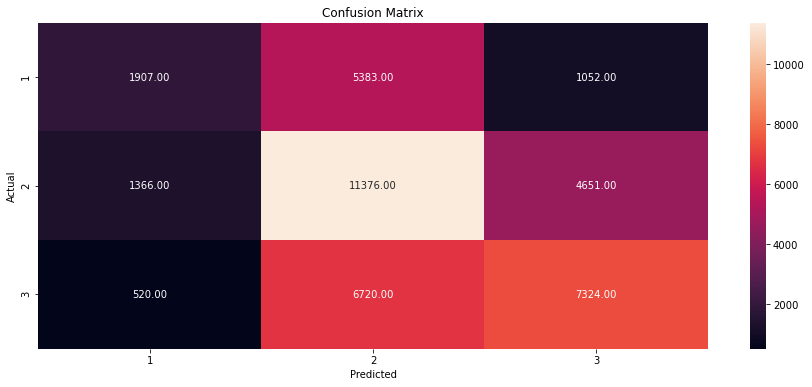

In [210]:
from sklearn.ensemble import AdaBoostClassifier
adb = AdaBoostClassifier()
model_function(adb,X_train,X_test,y_train,y_test)

### XGBoostClassifier

[21:53:06] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
***********************************************************************************************

Model Report for XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0, gpu_id=-1,
              importance_type='gain', interaction_constraints='',
              learning_rate=0.300000012, max_delta_step=0, max_depth=6,
              min_child_weight=1, missing=nan, monotone_constraints='()',
              n_estimators=100, n_jobs=8, num_parallel_tree=1,
              objective='multi:softprob', random_state=0, reg_alpha=0,
              reg_lambda=1, scale_pos_weight=None, subsample=1,
              tree_met

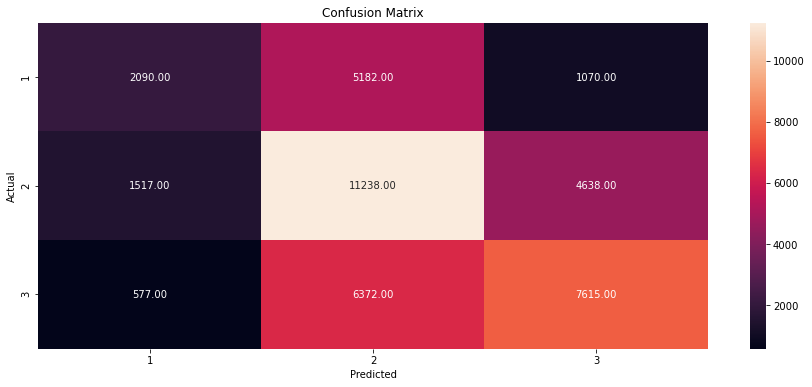

In [211]:
import xgboost as xgb
from xgboost import XGBClassifier
xgbc = XGBClassifier()
model_function(xgbc,X_train,X_test,y_train,y_test)

### CatBoostClassifier

***********************************************************************************************

Model Report for <catboost.core.CatBoostClassifier object at 0x0000015CC08239C8>

***********************************************************************************************
              precision    recall  f1-score   support

         1.0       0.51      0.26      0.34      8342
         2.0       0.49      0.65      0.56     17393
         3.0       0.57      0.52      0.55     14564

    accuracy                           0.52     40299
   macro avg       0.53      0.48      0.48     40299
weighted avg       0.53      0.52      0.51     40299



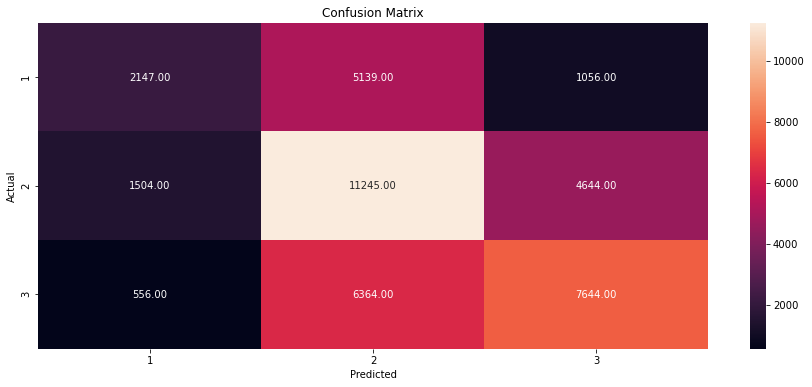

In [212]:
from catboost import CatBoostClassifier
cbc = CatBoostClassifier(verbose = 0)
model_function(cbc,X_train,X_test,y_train,y_test)